In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
print('Train Image Count:',len(os.listdir('data/training_images')))
print('Test Image Count:',len(os.listdir('data/testing_images')))

Train Image Count: 1001
Test Image Count: 176


In [3]:
data = pd.read_csv('data/train_solution_bounding_boxes.csv')
data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [4]:
data.isnull().sum()

image    0
xmin     0
ymin     0
xmax     0
ymax     0
dtype: int64

In [5]:
def img_path(image_name):
    return f'data/training_images/{image_name}'

1. Photo shape:  (380, 676, 3)
Name: vid_4_1000.jpg 
x_min: 281.25904489999994 
y_min: 187.0350708 
x_max: 327.7279305 
y_max: 223.22554700000003
-------------------------------------------------------
2. Photo shape:  (380, 676, 3)
Name: vid_4_10000.jpg 
x_min: 15.16353111 
y_min: 187.0350708 
x_max: 120.32995659999999 
y_max: 236.43018019999997
-------------------------------------------------------
3. Photo shape:  (380, 676, 3)
Name: vid_4_10040.jpg 
x_min: 239.1924747 
y_min: 176.76480049999998 
x_max: 361.96816210000003 
y_max: 236.43018019999997
-------------------------------------------------------


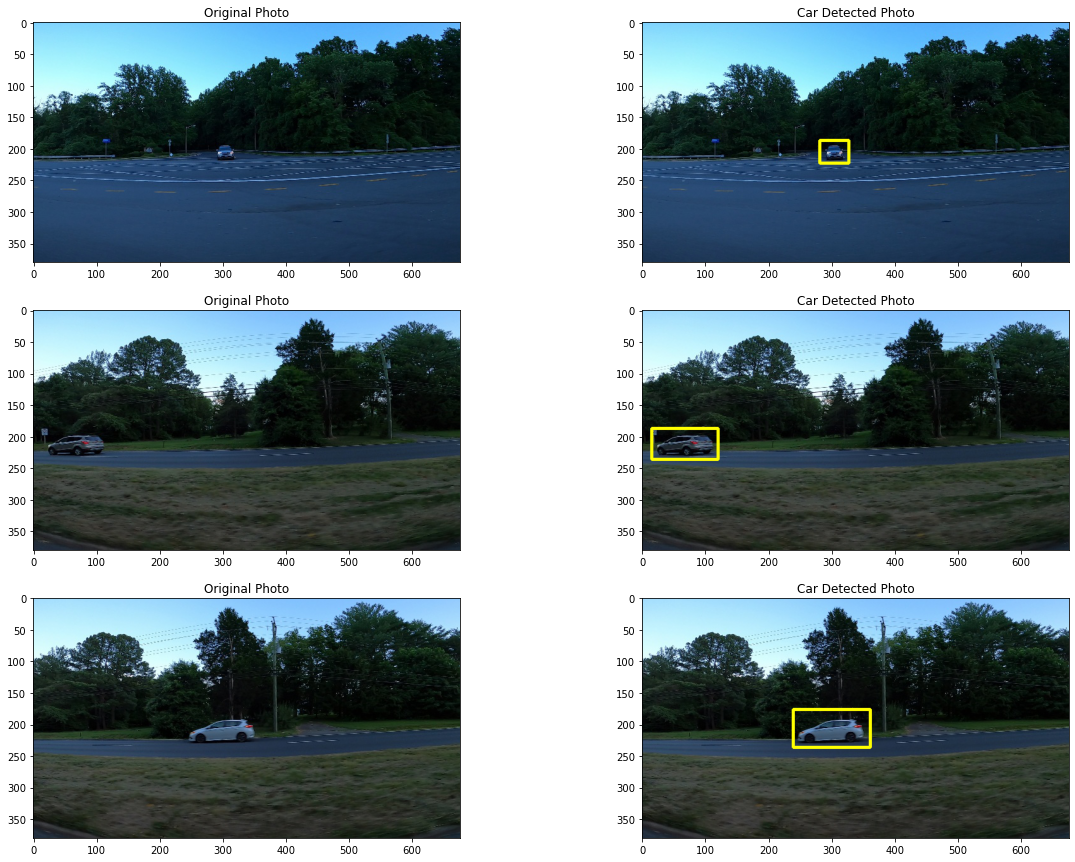

In [6]:
i = 0
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
for image_data in data.values:
    image_name,x_min,y_min,x_max,y_max = image_data
    image = plt.imread(img_path(image_name))
    axes[i][0].imshow(image)
    axes[i][0].set_title('Original Photo')
    print(f'{i+1}. Photo shape: ',image.shape)
    print('Name: {} \nx_min: {} \ny_min: {} \nx_max: {} \ny_max: {}'.format(image_name,x_min,y_min,x_max,y_max))
    print("-------------------------------------------------------")
    im_edge_1 = (int(x_min),int(y_min))
    im_edge_2 = (int(x_max),int(y_max))
    color = (255,255,0)
    thickness = 3
    cv2.rectangle(image,im_edge_1,im_edge_2,color,thickness)
    axes[i][1].imshow(image)
    axes[i][1].set_title('Car Detected Photo')
    i += 1
    if i == 3:
        break

In [7]:
cv2.setUseOptimized(True)
selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
image = cv2.imread(img_path(data.iloc[5,0]))
image = cv2.resize(image,(224,224))
selective_search.setBaseImage(image)
selective_search.switchToSelectiveSearchFast()
bbs = selective_search.process()
print("Bounty boxes coordinates: \n",bbs)

Bounty boxes coordinates: 
 [[  0   0 127  56]
 [ 70  27  47  70]
 [  0  45  44  88]
 ...
 [ 57   0 125 114]
 [  0   0 127 134]
 [  0   0 169  87]]


Shape:  (224, 224, 3)
Bounty boxes:  353


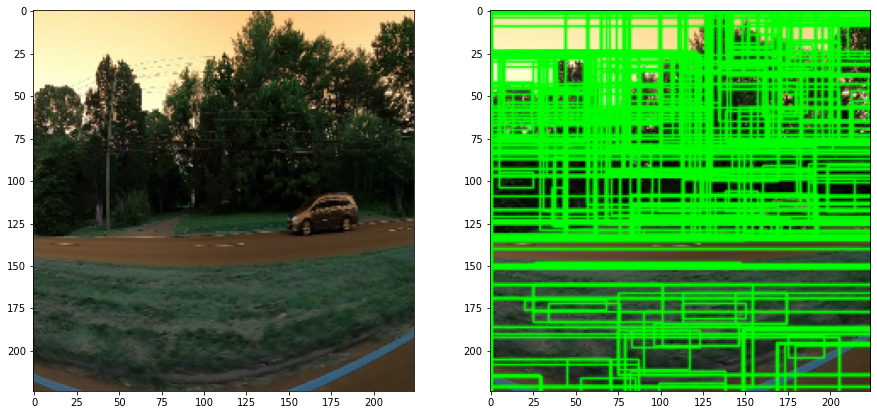

In [8]:
print('Shape: ',image.shape)
print('Bounty boxes: ',len(bbs))
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10),sharex = True)
ax1.imshow(image)
for bb in bbs:
    x, y, w, h = bb
    imOut = cv2.rectangle(image,(x,y), (x+w,y+h), (0,255,0), 1,cv2.LINE_AA)
ax2.imshow(imOut)

In [9]:
def bb_intersection_over_union(true_bounty_box,pred_bounty_box):
    x_min = max(true_bounty_box['x_min'],pred_bounty_box['x_min'])
    y_min = max(true_bounty_box['y_min'],pred_bounty_box['y_min'])
    x_max = min(true_bounty_box['x_max'],pred_bounty_box['x_max'])
    y_max = min(true_bounty_box['y_max'],pred_bounty_box['y_max'])
    
    inter_area = max(0,(x_max - x_min)) * max(0,(y_max - y_min))
    true_bounty_box_area = (true_bounty_box['x_max'] - true_bounty_box['x_min']) * (true_bounty_box['y_max'] - true_bounty_box['y_min'])
    pred_bounty_box_area = (pred_bounty_box['x_max'] - pred_bounty_box['x_min']) * (pred_bounty_box['y_max'] - pred_bounty_box['y_min'])
    iou = inter_area / float(true_bounty_box_area + pred_bounty_box_area - inter_area)
    return iou

In [10]:
import timeit
images = []
labels = []
label_0_count,label_1_count = 0,0
start_time = timeit.default_timer()
for image_data in data.values:
    true_bounty_box = {'x_min':int(image_data[1]), 'y_min':int(image_data[2]), 'x_max':int(image_data[3]), 'y_max':int(image_data[4])}
    image = cv2.imread(img_path(image_data[0]))
    selective_search.setBaseImage(image)
    selective_search.switchToSelectiveSearchFast()
    bbs = selective_search.process()
        
    for bb in bbs:
        pred_bounty_box = {'x_min':bb[0], 'y_min':bb[1], 'x_max':(bb[0]+bb[2]), 'y_max':(bb[1]+bb[3])}
        crop_image = cv2.resize(image[pred_bounty_box['y_min']:pred_bounty_box['y_max'],pred_bounty_box['x_min']:pred_bounty_box['x_max']],(224,224))
        if label_1_count<label_0_count:
            if 0.5<bb_intersection_over_union(true_bounty_box , pred_bounty_box):
                images.append(crop_image)
                labels.append(1)
                label_1_count += 1
        else:
            if 0.5<bb_intersection_over_union(true_bounty_box , pred_bounty_box):
                images.append(crop_image)
                labels.append(1)
                label_1_count += 1
            elif 0.0 < bb_intersection_over_union(true_bounty_box , pred_bounty_box):
                images.append(crop_image)
                labels.append(0)
                label_0_count += 1
    print("File Name: ",image_data[0]," Bounty Box Count: ",len(bbs)," Images Size: ",len(images)," Label Size: ",len(labels))
end_time = timeit.default_timer()
dataset_extraction_time = "%.2f" % ((end_time - start_time)/60)
print("------------------------------------------------")
print("Process Done! Images and labels saved in lists..")
print(f"Process time: {dataset_extraction_time} min")

File Name:  vid_4_1000.jpg  Bounty Box Count:  1101  Images Size:  13  Label Size:  13
File Name:  vid_4_10000.jpg  Bounty Box Count:  1456  Images Size:  47  Label Size:  47
File Name:  vid_4_10040.jpg  Bounty Box Count:  1403  Images Size:  55  Label Size:  55
File Name:  vid_4_10020.jpg  Bounty Box Count:  1489  Images Size:  63  Label Size:  63
File Name:  vid_4_10060.jpg  Bounty Box Count:  1315  Images Size:  91  Label Size:  91
File Name:  vid_4_10100.jpg  Bounty Box Count:  1537  Images Size:  93  Label Size:  93
File Name:  vid_4_10120.jpg  Bounty Box Count:  1430  Images Size:  123  Label Size:  123
File Name:  vid_4_10140.jpg  Bounty Box Count:  1544  Images Size:  129  Label Size:  129
File Name:  vid_4_1020.jpg  Bounty Box Count:  1117  Images Size:  129  Label Size:  129
File Name:  vid_4_1040.jpg  Bounty Box Count:  1146  Images Size:  135  Label Size:  135
File Name:  vid_4_10480.jpg  Bounty Box Count:  1663  Images Size:  157  Label Size:  157
File Name:  vid_4_10500.j

In [11]:
images = np.array(images)
labels = np.array(labels)

In [12]:
print("Car Images Count:",labels[labels == 1].size,"\nOther Images Count:",labels[labels == 0].size)
print("Images Data Shape: ",images.shape,"\nImages Labels Shape: ",labels.shape)

Car Images Count: 5290 
Other Images Count: 5291
Images Data Shape:  (10581, 224, 224, 3) 
Images Labels Shape:  (10581,)


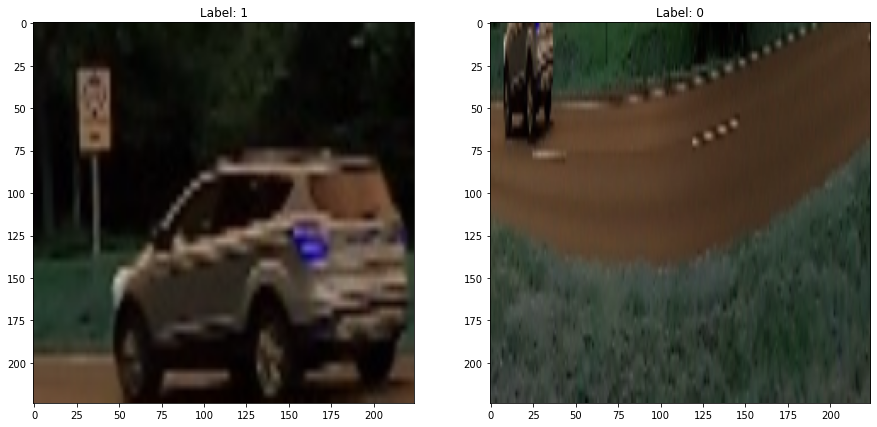

In [13]:
fig , (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10),sharex = True)
car_img_index = np.where(labels == 1)[0][20]
other_img_index = np.where(labels == 0)[0][20]
ax1.set_title(f'Label: {labels[car_img_index]}')
ax1.imshow(images[car_img_index])
ax2.set_title(f'Label: {labels[other_img_index]}')
ax2.imshow(images[other_img_index])

In [14]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(images,labels,test_size = 0.3 , random_state = 0)
print("x_train shape: ",x_train.shape)
print("x_test shape: ",x_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

x_train shape:  (7406, 224, 224, 3)
x_test shape:  (3175, 224, 224, 3)
y_train shape:  (7406,)
y_test shape:  (3175,)


In [15]:
from keras.applications import VGG16
vgg16_imagenet = VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')
vgg16_imagenet.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
for l in vgg16_imagenet.layers:
    print(l.name,'-',l.trainable)

input_1 - True
block1_conv1 - True
block1_conv2 - True
block1_pool - True
block2_conv1 - True
block2_conv2 - True
block2_pool - True
block3_conv1 - True
block3_conv2 - True
block3_conv3 - True
block3_pool - True
block4_conv1 - True
block4_conv2 - True
block4_conv3 - True
block4_pool - True
block5_conv1 - True
block5_conv2 - True
block5_conv3 - True
block5_pool - True


In [17]:
vgg16_imagenet.trainable = False
for l in vgg16_imagenet.layers:
    print(l.name,'-',l.trainable)

input_1 - False
block1_conv1 - False
block1_conv2 - False
block1_pool - False
block2_conv1 - False
block2_conv2 - False
block2_pool - False
block3_conv1 - False
block3_conv2 - False
block3_conv3 - False
block3_pool - False
block4_conv1 - False
block4_conv2 - False
block4_conv3 - False
block4_pool - False
block5_conv1 - False
block5_conv2 - False
block5_conv3 - False
block5_pool - False


In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GlobalAveragePooling2D
model = Sequential()
model.add(vgg16_imagenet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics='accuracy')

In [33]:
fitting_model = model.fit(x_train,y_train,epochs= 4,validation_data=(x_test,y_test))

Epoch 1/4
232/232 [==============================] - 1186s 5s/step - loss: 0.8464 - accuracy: 0.7800 - val_loss: 0.2745 - val_accuracy: 0.9257
Epoch 2/4
232/232 [==============================] - 1160s 5s/step - loss: 0.4053 - accuracy: 0.8797 - val_loss: 0.2117 - val_accuracy: 0.9383
Epoch 3/4
232/232 [==============================] - 1161s 5s/step - loss: 0.3127 - accuracy: 0.9013 - val_loss: 0.1872 - val_accuracy: 0.9411
Epoch 4/4
232/232 [==============================] - 1139s 5s/step - loss: 0.2647 - accuracy: 0.9094 - val_loss: 0.1792 - val_accuracy: 0.9420


In [35]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [36]:
def pred_best_bounty_box(path):
    img = cv2.imread(path)
    selective_search.setBaseImage(img)
    selective_search.switchToSelectiveSearchFast()
    test_img_bounty_boxes = selective_search.process()
    best_pred = 0
    best_bb = []
    for bbs in test_img_bounty_boxes:
        x, y, w, h = bbs
        img_data = img[y:(y+h),x:(x+w)]
        img_data = cv2.resize(img_data,(224,224)).reshape(1,224,224,3)
        pred = model.predict(img_data)
        if pred[0] > best_pred:
            best_pred = pred[0]
            best_bb = [x,y,x+w,y+h]
    return best_pred,best_bb

In [37]:
# 'data/testing_images/vid_5_31100.jpg'
def plot_pred_bounty_box(path,best_pred,best_bb):
    img = cv2.imread(path)
    plt.figure(figsize = (12,8))
    plt.title('Original Photo')
    plt.imshow(img)
    cv2.rectangle(img,(best_bb[0],best_bb[1]),(best_bb[2],best_bb[3]),(255,255,0),2)
    plt.figure(figsize = (12,8))
    acc = '%.2f' % (best_pred[0]*100)
    plt.title(f'Best bounty box predict by CNN model. Accuracy: %{acc}')
    plt.imshow(img)

In [38]:
image_path = 'data/testing_images/vid_5_31100.jpg'
best_pred, best_bb = pred_best_bounty_box(image_path)

1/1 [==============================] - 0s 129ms/step


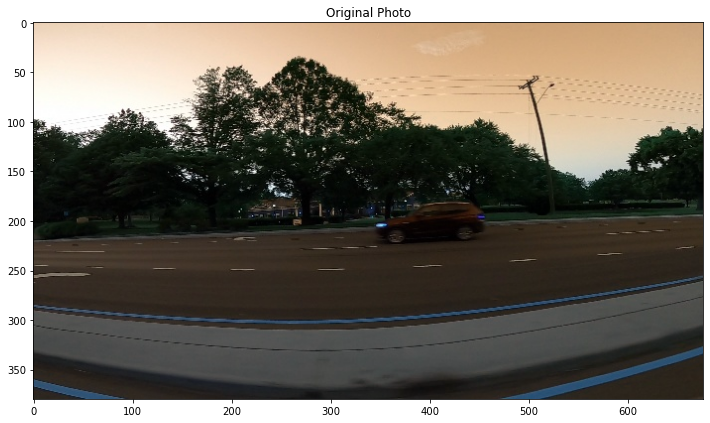

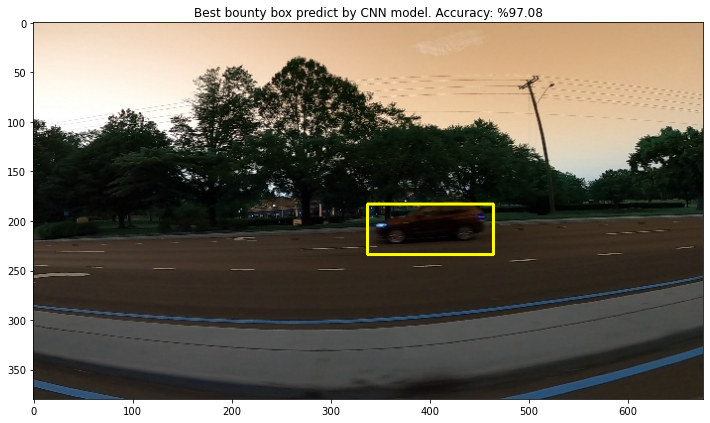

In [39]:
plot_pred_bounty_box(image_path,best_pred,best_bb)

In [42]:
image_path = 'data/testing_images/vid_5_27620.jpg'
best_pred, best_bb = pred_best_bounty_box(image_path)

1/1 [==============================] - 0s 129ms/step


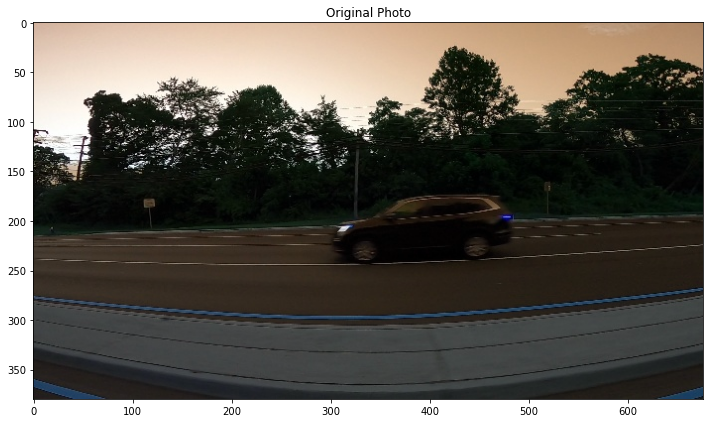

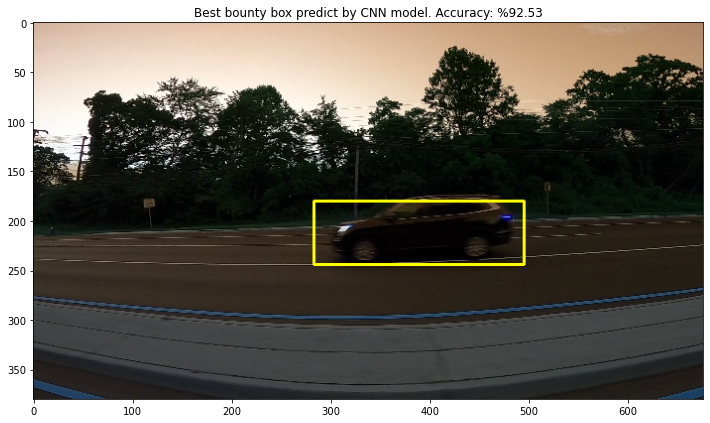

In [43]:
plot_pred_bounty_box(image_path,best_pred,best_bb)